In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import datetime as dt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import warnings
warnings.filterwarnings('ignore')

In [25]:
# Configuración de números flotantes a 3 decimales
pd.set_option('display.float_format','{:.3f}'.format)

# Estilo de visualización
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

## CARGA Y EXPLORACIÓN DE DATOS

In [26]:
url = "https://raw.githubusercontent.com/PabloJRW/super_store_projects/main/datasets/Superstore.csv"
# Carga de datos
data = pd.read_csv(url, encoding='windows-1252', date_parser='Order Date')
data.sample(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
4287,4288,CA-2017-127516,12/28/2017,1/3/2018,Standard Class,EH-14005,Erica Hernandez,Home Office,United States,Nashville,...,37211,South,OFF-ST-10000736,Office Supplies,Storage,Carina Double Wide Media Storage Towers in Nat...,64.784,1,0.200,-12.957
8524,8525,CA-2017-161172,3/16/2017,3/16/2017,Same Day,SP-20920,Susan Pistek,Consumer,United States,Columbus,...,43229,East,TEC-PH-10004348,Technology,Phones,OtterBox Defender Series Case - iPhone 5c,44.376,2,0.400,-7.396
1863,1864,US-2016-100839,10/13/2016,10/17/2016,Standard Class,NC-18625,Noah Childs,Corporate,United States,Aurora,...,80013,West,FUR-TA-10004575,Furniture,Tables,Hon 5100 Series Wood Tables,727.450,5,0.500,-465.568
2107,2108,CA-2015-164882,10/31/2015,10/31/2015,Same Day,SG-20080,Sandra Glassco,Consumer,United States,Redlands,...,92374,West,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,19.980,1,0.000,9.391
285,286,CA-2015-130883,9/26/2015,10/2/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Portland,...,97206,West,OFF-PA-10004100,Office Supplies,Paper,Xerox 216,31.104,6,0.200,10.886


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [28]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Row ID,9994.000,4997.500,2885.164,1.000,2499.250,4997.500,7495.750,9994.000
Postal Code,9994.000,55190.379,32063.693,1040.000,23223.000,56430.500,90008.000,99301.000
Sales,9994.000,229.858,623.245,0.444,17.280,54.490,209.940,22638.480
Quantity,9994.000,3.790,2.225,1.000,2.000,3.000,5.000,14.000
Discount,9994.000,0.156,0.206,0.000,0.000,0.200,0.200,0.800
Profit,9994.000,28.657,234.260,-6599.978,1.729,8.666,29.364,8399.976


In [29]:
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

## TRANSFORMACIONES DE DATOS

In [30]:
# Datos de los corporativos
consumer_data = data[data.Segment=='Consumer']

# Transformación de tipo de dato
consumer_data['Order Date'] = pd.to_datetime(consumer_data['Order Date'])

# Seleccinar los datos del último año - 2017
consumer_data = consumer_data[consumer_data['Order Date'] >= '2017']

# Calculo de variable 'Discount'
consumer_data['Discount'] = consumer_data['Discount']  * consumer_data['Sales'] 

In [31]:
# Datos agrupados 
consumer_data = consumer_data.groupby(['Customer ID','Order ID','Order Date']).sum()
consumer_data.drop(['Row ID','Postal Code'], axis=1, inplace=True)
consumer_data = consumer_data.reset_index([0,1,2])

consumer_data.sample(3)

,Customer ID,Order ID,Order Date,Sales,Quantity,Discount,Profit
676,RB-19330,CA-2017-106068,2017-10-23,337.818,9,73.421,-74.306
357,HG-15025,CA-2017-117821,2017-06-12,63.920,2,12.784,19.176
759,SG-20470,US-2017-102890,2017-06-30,1044.630,5,417.852,-295.978


In [32]:
# CREATING RFM FEATURES
# =============================================================================================

snapshot_date = consumer_data['Order Date'].max() + dt.timedelta(days=1)

# Aggregate data on a customer level
consumerData = consumer_data.groupby('Customer ID').agg({'Order Date': lambda x: (snapshot_date - x.max()).days,
                                          'Order ID': 'count',
                                          'Sales': 'sum'})

# Rename columns
consumerData.rename(columns={'Order Date': 'Recency',
                        'Order ID': 'Frequency',
                        'Sales': 'MonetaryValue'}, inplace=True)

consumerData.sample(5).round(2)

,Recency,Frequency,MonetaryValue
Customer ID,,,
DW-13540,99,3,239.850
TS-21505,12,4,868.950
CK-12205,40,4,1578.620
CT-11995,97,3,599.420
HZ-14950,36,4,864.640


#### VARIABLES SIN ESCALADO

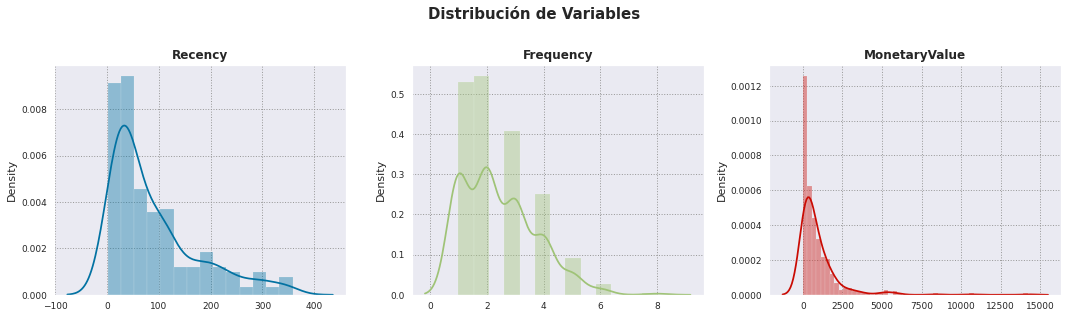

In [33]:
# DISTRIBUCIONES DE VARIABLES SIN ESCALAR
# ==============================================================================

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes = axes.flat

for i, feature in enumerate(consumerData.columns):
    sns.distplot(
        x       = consumerData[feature],
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(feature, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
fig.suptitle('Distribución de Variables', y=1.1,fontsize = 15, fontweight = "bold")
plt.show()

In [34]:
consumerData.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Recency,361.000,88.740,84.240,1.000,28.000,56.000,120.000,358.000
Frequency,361.000,2.430,1.280,1.000,1.000,2.000,3.000,8.000
MonetaryValue,361.000,919.400,1395.870,2.810,186.540,520.220,1124.440,14203.280


#### PREPROCESAMINETO DE VARIABLES

In [35]:
# Transformación logarítmica
consumerData_log = np.log(consumerData)

# x - X.mean / X.std
scaler = StandardScaler()

# 
scaler.fit(consumerData_log)

# Escalado de variables
scaled_features = scaler.transform(consumerData_log)

# Variables escaladas - DataFrame
scaled_features = pd.DataFrame(scaled_features, index=consumerData.index, columns=consumerData.columns)
scaled_features.sample(5).round(3)

,Recency,Frequency,MonetaryValue
Customer ID,,,
PF-19225,0.680,-0.091,0.248
JH-15820,1.051,-0.091,0.054
MS-17770,0.733,-1.357,-0.456
ES-14020,-0.229,-0.091,1.361
TM-21010,0.592,0.650,0.209


#### VARIABLES ESCALADAS

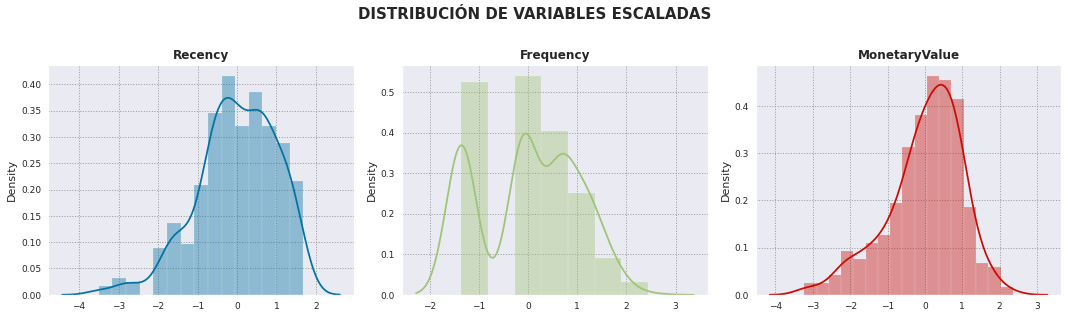

In [36]:
# DISTRIBUCIONES DE VARIABLES ESCALADAS
# ==============================================================================

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes = axes.flat


for i, feature in enumerate(scaled_features.columns):
    sns.distplot(
        x       = scaled_features[feature],
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(feature, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('DISTRIBUCIÓN DE VARIABLES ESCALADAS', y=1.1, fontsize = 15, fontweight = "bold");

In [37]:
scaled_features.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
Recency,361.000,-0.000,1.001,-3.504,-0.565,0.046,0.718,1.682
Frequency,361.000,0.000,1.001,-1.357,-1.357,-0.091,0.650,2.441
MonetaryValue,361.000,-0.000,1.001,-3.226,-0.482,0.189,0.693,2.352


## KMeans

#### MÉTODO DE CODO

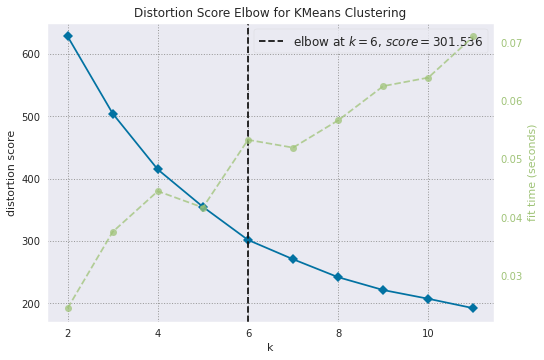

In [38]:
# MÉTODO DE CODO
# ============================================================================
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(scaled_features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()


#### ENTRENAMIENTO DEL MODELO - KMEANS

In [39]:
# Modelo - KMeans
kmeans_model = KMeans(n_clusters=6, random_state=42)

# Modelo entrenado
kmeans_model.fit_transform(scaled_features)

consumerData['labels_5k'] = kmeans_model.labels_

kmeansData = consumerData.groupby('labels_5k').agg({'Recency':'mean',
                                           'Frequency':'mean',
                                           'MonetaryValue':['mean','count']})
kmeansData.round(2)

Recency Frequency MonetaryValue      
             mean      mean          mean count
labels_5k                                      
0         163.350     1.180        25.410    40
1          47.230     3.540      1773.870   100
2           8.430     3.620      1656.410    40
3          27.870     1.780       331.120    55
4         167.980     1.000       468.710    53
5         137.050     2.450       605.360    73

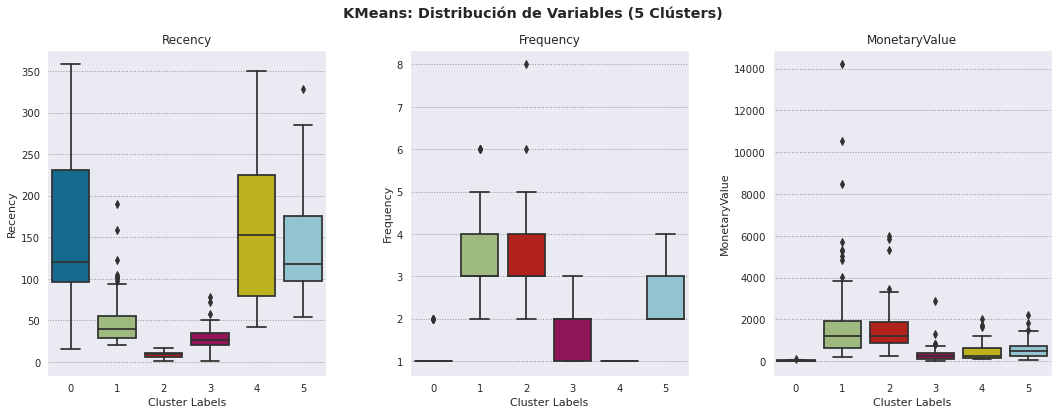

In [40]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
plt.suptitle("KMeans: Distribución de Variables (5 Clústers)", fontweight='bold')

for i, col in enumerate(consumerData.columns[0:3]):
    ax[i].set_title(col)
    sns.boxplot(x=consumerData.labels_5k, y=consumerData[col], ax=ax[i])
    ax[i].set_xlabel("Cluster Labels")

plt.subplots_adjust(wspace=.3) 
plt.show()

In [41]:
fig = px.scatter_3d(consumerData, x="Recency", y="Frequency",z="MonetaryValue", color="labels_5k")
#fig.write_html("scater_3d.html")
fig.show()

## Hierarchical Clustering

In [42]:
# Modelo de segmentación jerárquica
hierarchy_model = linkage(scaled_features, method='ward')

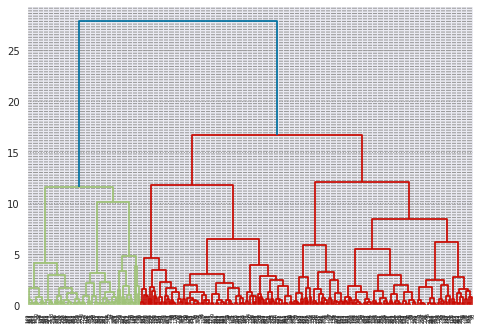

In [43]:
# Dendrograma
drendogram = dendrogram(hierarchy_model)

# Visualización del dendrograma
plt.show()

In [44]:
# Punto de corte
cluster_labels = fcluster(hierarchy_model, 11, criterion='distance')

hierarchicalData = consumerData.copy()

# Asignación de las etiquetas de clusters a los datos
hierarchicalData['labels_H'] = cluster_labels

hierarchicalData.groupby('labels_H').agg({'Recency':'mean',
                                                   'Frequency':'mean',
                                                   'MonetaryValue':['mean','count']}).round(2)



Recency Frequency MonetaryValue      
            mean      mean          mean count
labels_H                                      
1        190.090     1.000       366.670    44
2        127.310     1.080        44.490    48
3          7.820     3.850      1529.120    34
4         52.920     3.730      1617.850    89
5         33.120     1.630      1803.320    41
6        106.910     2.380       416.400   105

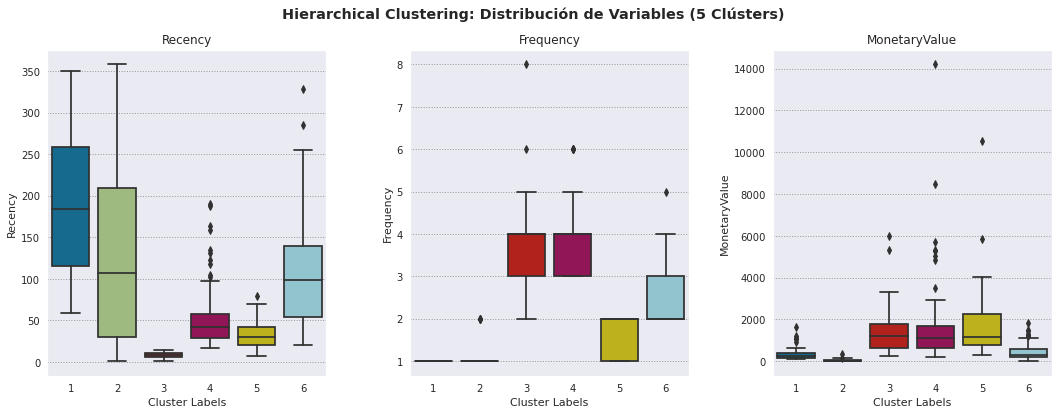

In [45]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
plt.suptitle("Hierarchical Clustering: Distribución de Variables (5 Clústers)", fontweight='bold')

for i, col in enumerate(hierarchicalData.columns[0:3]):
    ax[i].set_title(col)
    sns.boxplot(x=hierarchicalData.labels_H, y=hierarchicalData[col], ax=ax[i])
    ax[i].set_xlabel("Cluster Labels")

plt.subplots_adjust(wspace=.3) 
plt.show()

In [46]:
fig = px.scatter_3d(hierarchicalData, x="Recency", y="Frequency",z="MonetaryValue", color="labels_H")
fig.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1b658b7b-c8b6-4d41-91f4-450f5e308d93' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>